In [50]:
from dotenv import load_dotenv
import os
import sys

# Agregar el directorio raíz del proyecto al path de Python
sys.path.insert(0, os.path.abspath('..'))

# Cargar variables de entorno desde .env
load_dotenv('../.env')

# Verificar que se cargaron correctamente
print(f"PGHOST: {os.getenv('PGHOST')}")
print(f"PGUSER: {os.getenv('PGUSER')}")
print(f"PGDATABASE: {os.getenv('PGDATABASE')}")

PGHOST: voz-publica2.postgres.database.azure.com
PGUSER: diegomancera
PGDATABASE: postgres


In [51]:
import os
import asyncpg
#Database connection
pg_host = os.environ["PGHOST"]
pg_user = os.environ["PGUSER"]
pg_password = os.environ["PGPASSWORD"]
pg_db = os.environ["PGDATABASE"]
pg_port = os.environ.get("PGPORT", "5432")
DATABASE_URL = f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db}?sslmode=require"

pool = None
async def get_pool():
    global pool
    if pool is None:
        pool = await asyncpg.create_pool(
            DATABASE_URL,
            min_size=1,
            max_size=10,
            command_timeout=60
        )
    return pool

In [ ]:
# Funciones de análisis
import numpy as np
from collections import defaultdict
import json

async def fetch_relevant_embeddings(
    concept_embedding: list[float],
    similarity_threshold: float = 0.6
):
    pool = await get_pool()
    
    # Convertir el embedding a formato de string para pgvector
    embedding_str = '[' + ','.join(map(str, concept_embedding)) + ']'

    sql = """
    SELECT
      date_trunc('month', m.published_at) AS period,
      s.embedding
    FROM speech_turns s
    JOIN raw_transcripts_meta m
      ON s.doc_id = m.doc_id
    WHERE
      m.published_at IS NOT NULL
      AND 1 - (s.embedding <=> $1::vector) > $2
    ORDER BY period;
    """

    async with pool.acquire() as conn:
        rows = await conn.fetch(sql, embedding_str, similarity_threshold)

    return rows

def group_by_period(rows):
    """
    Agrupa los embeddings por período (mes).
    Devuelve un diccionario donde las claves son los períodos y los valores son listas de embeddings
    """
    buckets = defaultdict(list)

    for row in rows:
        period = row["period"]
        # Convertir el embedding de string a numpy array
        embedding_str = row["embedding"]
        if isinstance(embedding_str, str):
            # Si es string, convertir de formato "[1,2,3]" a array
            embedding = np.array(json.loads(embedding_str))
        else:
            # Si ya es una lista o array, convertir directamente
            embedding = np.array(embedding_str)
        buckets[period].append(embedding)

    return buckets

In [53]:
# Análisis del concepto
from postprocessing_helpers import embed_text

def get_concept_embedding(concept: str) -> list[float]:
    return embed_text(concept)

concept = "seguridad pública"
concept_embedding = get_concept_embedding(concept)

relevant_embeddings = await fetch_relevant_embeddings(concept_embedding)
print(f"Rows fetched: {len(relevant_embeddings)}")

relevant_embeddings_grouped = group_by_period(relevant_embeddings)
print(f"Periods found: {len(relevant_embeddings_grouped)}")

Rows fetched: 17
Periods found: 10


In [54]:
relevant_embeddings_grouped


defaultdict(list,
            {datetime.datetime(2024, 10, 1, 0, 0, tzinfo=datetime.timezone.utc): [array([ 0.04212546,  0.03628488,  0.07765737, ..., -0.00366308,
                     -0.01142679,  0.00448219], shape=(1536,)),
              array([ 0.02028528,  0.02245303,  0.08336854, ..., -0.01370251,
                      0.0134042 ,  0.01746125], shape=(1536,))],
             datetime.datetime(2024, 12, 1, 0, 0, tzinfo=datetime.timezone.utc): [array([ 0.05516774,  0.00821689,  0.01227029, ...,  0.00131444,
                      0.0095896 , -0.0225333 ], shape=(1536,)),
              array([ 0.04710948,  0.01231852,  0.0339448 , ..., -0.00345597,
                     -0.00432919,  0.00122312], shape=(1536,))],
             datetime.datetime(2025, 2, 1, 0, 0, tzinfo=datetime.timezone.utc): [array([ 0.05461263,  0.02372797,  0.01267605, ...,  0.00051125,
                      0.02628959, -0.01329664], shape=(1536,))],
             datetime.datetime(2025, 4, 1, 0, 0, tzinfo=datetime.t

In [55]:
#Average maeaning by period
def average_embedding(embeddings: list[np.ndarray]) -> np.ndarray:
    return np.mean(embeddings, axis=0)

buckets = relevant_embeddings_grouped

period_embeddings = {}
for period, vectors in buckets.items():
    period_embeddings[period] = average_embedding(vectors)

#Estoy representando el marco semántico dominante del concepto en cada periodo.

In [56]:
# Medir campo semantico entre periodos
from numpy.linalg import norm

def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    return 1 - np.dot(a, b) / (norm(a) * norm(b))

def semantic_drift(period_embeddings: dict):
    periods = sorted(period_embeddings.keys())
    drift = []

    for i in range(1, len(periods)):
        t_prev = periods[i - 1]
        t_curr = periods[i]

        dist = cosine_distance(
            period_embeddings[t_prev],
            period_embeddings[t_curr]
        )

        drift.append({
            "from": t_prev,
            "to": t_curr,
            "semantic_change": float(dist)
        })

    return drift

semantic_drift_results = semantic_drift(period_embeddings)

In [57]:
semantic_drift_results

[{'from': datetime.datetime(2024, 10, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'to': datetime.datetime(2024, 12, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'semantic_change': 0.22696462042661314},
 {'from': datetime.datetime(2024, 12, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'to': datetime.datetime(2025, 2, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'semantic_change': 0.2525924760396583},
 {'from': datetime.datetime(2025, 2, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'to': datetime.datetime(2025, 4, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'semantic_change': 0.15332211149996877},
 {'from': datetime.datetime(2025, 4, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'to': datetime.datetime(2025, 5, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'semantic_change': 0.17880396115261787},
 {'from': datetime.datetime(2025, 5, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'to': datetime.datetime(2025, 6, 1, 0, 0, tzinfo=datetime.timezone.utc),
  'semantic_change': 0.1958901475734901},
 {'from': datetime.datet

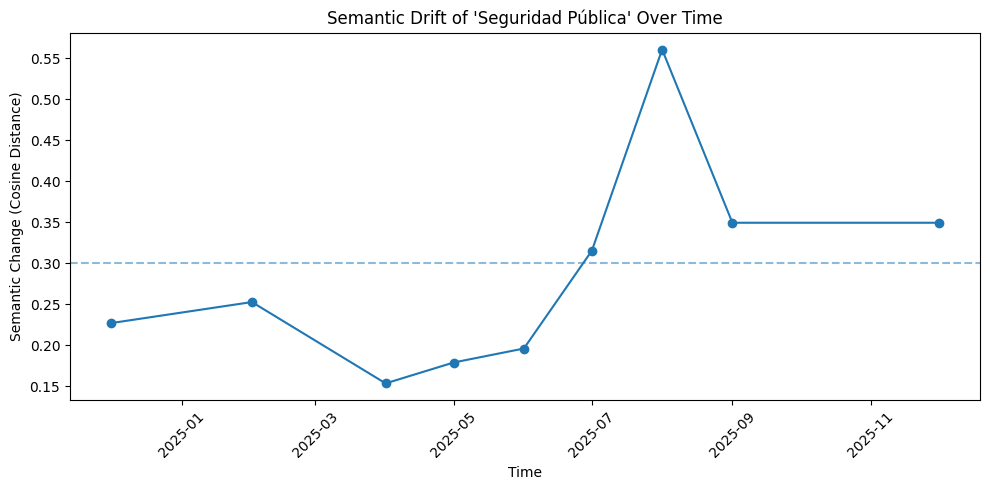

In [58]:
import matplotlib.pyplot as plt
from datetime import datetime

# Prepare data
dates = [item["to"] for item in semantic_drift_results]
changes = [item["semantic_change"] for item in semantic_drift_results]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(dates, changes, marker='o')
plt.axhline(0.3, linestyle='--', alpha=0.5)

plt.title("Semantic Drift of 'Seguridad Pública' Over Time")
plt.xlabel("Time")
plt.ylabel("Semantic Change (Cosine Distance)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [61]:
from datetime import datetime

async def fetch_sentences(
    concept_embedding: list[float],
    date_range: tuple[str, str],
    similarity_threshold: float = 0.6
):
    pool = await get_pool()
    
    # Convertir el embedding a formato de string para pgvector
    embedding_str = '[' + ','.join(map(str, concept_embedding)) + ']'
    
    # Convertir strings de fecha a objetos datetime
    start_date = datetime.strptime(date_range[0], "%Y-%m-%d")
    end_date = datetime.strptime(date_range[1], "%Y-%m-%d")

    sql = """
        SELECT
        s.speaker_raw,
        s.speaker_normalized,
        s.embedding,
        s.text,
        m.published_at,
        1 - (s.embedding <=> $1::vector) AS similarity
        FROM speech_turns s
        JOIN raw_transcripts_meta m
        ON s.doc_id = m.doc_id
        WHERE
        m.published_at BETWEEN $2 AND $3
        AND s.embedding IS NOT NULL
        AND s.speaker_raw IS NOT NULL
        AND length(s.text) > 100
        AND 1 - (s.embedding <=> $1::vector) > $4
        ORDER BY similarity DESC
        LIMIT 200;
    """
    async with pool.acquire() as conn:
        rows = await conn.fetch(
            sql,
            embedding_str,
            start_date,
            end_date,
            similarity_threshold
        )
    return rows


PRE_RANGE  = ("2024-10-01", "2025-07-01")
POST_RANGE = ("2025-08-01", "2025-12-01")

pre_rows = await fetch_sentences(concept_embedding, PRE_RANGE)
post_rows = await fetch_sentences(concept_embedding, POST_RANGE)

def top_sentences(rows, n=10):
    return [
        {
            "speaker": r["speaker_normalized"],
            "date": r["published_at"],
            "text": r["text"],
            "similarity": r["similarity"]
        }
        for r in rows[:n]
    ]

In [62]:
# Pre period top sentences
pre_top_sentences = top_sentences(pre_rows)
post_top_sentences = top_sentences(post_rows)
print("Pre-period top sentences:")
for sentence in pre_top_sentences:
    print(f"- ({sentence['date'].date()}) [{sentence['speaker']}] {sentence['text']} (sim: {sentence['similarity']:.4f})")
# Post period top sentences
print("\nPost-period top sentences:")
for sentence in post_top_sentences:
    print(f"- ({sentence['date'].date()}) [{sentence['speaker']}] {sentence['text']} (sim: {sentence['similarity']:.4f})")

Pre-period top sentences:
- (2024-10-08) [Omar García Harfuch]  coordinación. La seguridad es un problema que requiere de una responsabilidad compartida y una respuesta unificada. Es por ello que vamos a tener una coordinación absoluta entre las instituciones del Gabinete de Seguridad y también, cuando sea necesario, con las autoridades estatales. El día de hoy, por instrucciones de la doctora Claudia Sheinbaum, miembros del Gabinete de Seguridad nos trasladaremos a Culiacán para supervisar tareas y reunirnos también con el gobernador. Es muy importante trabajar de la mano con mecanismos permanentes de colaboración activa. Asimismo, hemos establecido tres objetivos principales para la construcción de una paz duradera en el país: El primero es la disminución de la incidencia delictiva, principalmente de los homicidios dolosos y delitos de alto impacto como la extorsión. Neutralizar generadores de violencia y redes criminales con atención a zonas de alta incidencia delictiva. Fortalecer 

In [68]:
# Agrupación por speaker
from collections import defaultdict
import numpy as np
import json

def group_embeddings_by_speaker(rows):
    buckets = defaultdict(list)

    for r in rows:
        speaker = r.get("speaker_normalized") or r.get("speaker_raw")

        # Skip rows with no speaker at all
        if not speaker:
            continue

        embedding_data = r["embedding"]
        if isinstance(embedding_data, str):
            embedding = np.array(json.loads(embedding_data))
        else:
            embedding = np.array(embedding_data)

        buckets[speaker].append(embedding)

    return buckets

pre_grouped = group_embeddings_by_speaker(pre_rows)
post_grouped = group_embeddings_by_speaker(post_rows)

print("Number of speakers:", len(pre_grouped))
print("Sample speakers:", list(pre_grouped.keys())[:10])

print("Number of speakers:", len(post_grouped))
print("Sample speakers:", list(post_grouped.keys())[:10])





Number of speakers: 3
Sample speakers: ['Omar García Harfuch', 'Voz Mujer', 'Marcela Figueroa Franco']
Number of speakers: 1
Sample speakers: ['Omar García Harfuch']


In [ ]:
# TODO: Minimo de evidencia??
def average_embeddings(grouped):
    return {
        speaker: np.mean(vectors, axis=0)
        for speaker, vectors in grouped.items()
        if len(vectors) >= 2  # mínimo de evidencia
    }
pre_averaged = average_embeddings(pre_grouped)
post_averaged = average_embeddings(post_grouped)

print("Number of speakers with averaged embeddings (pre):", len(pre_averaged))
print("Number of speakers with averaged embeddings (post):", len(post_averaged))    

Number of speakers with averaged embeddings (pre): 1
Number of speakers with averaged embeddings (post): 1


In [72]:
# Drift by speaker
from scipy.spatial.distance import cosine
def speaker_drift(pre_avg, post_avg):
    drift = {}
    for speaker in pre_avg:
        if speaker in post_avg:
            drift[speaker] = cosine(pre_avg[speaker], post_avg[speaker])
    return dict(sorted(drift.items(), key=lambda x: x[1], reverse=True))

speaker_semantic_drift = speaker_drift(pre_averaged, post_averaged)

In [73]:
speaker_semantic_drift

{'Omar García Harfuch': np.float64(0.14273695641090844)}

In [77]:
def format_excerpts(sentences, max_items=10):
    """
    Formats top sentences into a controlled text block for the LLM.
    """
    lines = []
    for s in sentences[:max_items]:
        line = (
            f"- ({s['date'].date()}) "
            f"[{s['speaker']}] "
            f"{s['text'].strip()}"
        )
        lines.append(line)

    return "\n".join(lines)

from openai import AzureOpenAI

# Embedding model settings from environment variables
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_api_key = os.environ["AZURE_OPENAI_API_KEY"]
azure_openai_api_version = os.environ.get("AZURE_OPENAI_API_VERSION", "2024-12-01-preview")
azure_openai_chat_deployment = "gpt-4.1"

def explain_semantic_drift(
    concept: str,
    drift_score: float,
    pre_sentences: list[dict],
    post_sentences: list[dict],
    azure_openai_endpoint: str,
    azure_openai_api_key: str,
    azure_openai_api_version: str,
    model: str = "gpt-4.1"
) -> str:
    """
    Uses an LLM to interpret semantic drift between two time periods.
    The LLM is constrained to the provided excerpts only.
    """

    pre_block = format_excerpts(pre_sentences)
    post_block = format_excerpts(post_sentences)

    system_prompt = (
        "You are a discourse analyst assisting with semantic analysis.\n"
        "You MUST rely ONLY on the provided excerpts.\n"
        "Do NOT speculate beyond the text.\n"
        "Cite specific phrases or patterns when making claims."
    )

    user_prompt = f"""
We measured a semantic drift score of approximately {drift_score:.2f}
for the concept "{concept}" between two time periods.

TASK:
1. Compare how the concept is framed in each period.
2. Identify changes in emphasis, scope, or framing.
3. Point to concrete textual evidence.
4. Explain how these differences plausibly account for the measured drift.

PRE-PERIOD EXCERPTS:
{pre_block}

POST-PERIOD EXCERPTS:
{post_block}

Respond using the following structure:

- Core framing (pre vs post)
- Concepts that gained prominence
- Concepts that lost prominence
- Overall semantic shift (grounded in text)
"""

    client = AzureOpenAI(
        azure_endpoint=azure_openai_endpoint,
        api_key=azure_openai_api_key,
        api_version=azure_openai_api_version
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.2,
        max_completion_tokens=2000
    )

    return response.choices[0].message.content


In [78]:
explanation = explain_semantic_drift(
    concept="seguridad pública",
    drift_score=0.56,
    pre_sentences=pre_top_sentences,
    post_sentences=post_top_sentences,
    azure_openai_endpoint=azure_openai_endpoint,
    azure_openai_api_key=azure_openai_api_key,
    azure_openai_api_version=azure_openai_api_version
)

# Save explanation to text file



In [79]:
# Save explanation to text file
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"semantic_drift_analysis_{concept.replace(' ', '_')}_{timestamp}.txt"

with open(filename, 'w', encoding='utf-8') as f:
    f.write(f"Semantic Drift Analysis\n")
    f.write(f"Concept: {concept}\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Pre-period: {PRE_RANGE[0]} to {PRE_RANGE[1]}\n")
    f.write(f"Post-period: {POST_RANGE[0]} to {POST_RANGE[1]}\n")
    f.write(f"\n{'='*80}\n\n")
    f.write(explanation)

print(f"Analysis saved to: {filename}")

Analysis saved to: semantic_drift_analysis_seguridad_pública_20251218_223033.txt
